# Epsilon Clustering
Cluster splats that are within an epsilon distance of each other.

In [17]:
# Path to the CSV file containing the collected splats.
CSV_FILE_PATH = "data/collected_splats.csv"

# Epsilon distance.
EPSILON = 0.11

In [18]:
import numpy as np
import polars as pl

from constants import IMAGE_HEIGHT, IMAGE_WIDTH

## Load Data From CSV

In [19]:
# Define the column names.
column_names = [f"gaussian_{i}_{part}" for i in range(500) for part in
                ["alpha", "depth", "color_r", "color_g", "color_b"]]
column_names = ["sample_index", "out_color_r", "out_color_g", "out_color_b", "background_r", "background_g",
                "background_b"] + column_names

# Define schema.
schema_dict = {name: pl.Float32 for name in column_names}
schema_dict["sample_index"] = pl.UInt32
schema_dict["background_r"] = pl.UInt8
schema_dict["background_g"] = pl.UInt8
schema_dict["background_b"] = pl.UInt8
schema = pl.Schema(schema_dict)

In [20]:
# Load data.
data = pl.scan_csv(CSV_FILE_PATH, schema=schema)

## Extract the Splats from the data

In [21]:
# Collect the raw splats.
raw_splats = data.select(
    pl.all().exclude("sample_index", "out_color_r", "out_color_g", "out_color_b", "background_r", "background_g",
                     "background_b")).collect().to_numpy()

# Reshape into splats table per pixel.
splats = raw_splats.reshape((IMAGE_HEIGHT * IMAGE_WIDTH, raw_splats.shape[1] // 5, 5))

# Cluster Splats
For each pixel, take a splat and
1. If there are no clusters, create a new dictionary entry with the splat's depth as the key and the alpha and color as the value.
2. If there are clusters, find the closest cluster by EPSILON distance and add it to that splats dictionary entry.
3. If 2 fails, create a new dictionary entry. 

In [22]:
from tqdm.auto import tqdm
from joblib import Parallel, delayed

In [39]:
def cluster_splats(splats_to_cluster, epsilon):
    """Cluster splats that are within an epsilon distance of each other."""

    def cluster_pixel(pixel_splats):
        """Compute clustering on a single pixel."""

        # Define clustering dictionary: depth -> [(alpha, color)].
        pixel_clustering = {}

        # Loop through each splat.
        for splat in pixel_splats:
            splat_alpha, splat_depth, *splat_color = splat
            splat_color = np.array(splat_color)
            # Skip transparent splats.
            if splat_alpha == 0:
                continue

            # Case 1: No clusters.
            if not pixel_clustering:
                pixel_clustering[splat_depth] = [(splat_alpha, splat_color)]
                continue

            # Case 2: Cluster is within epsilon distance.
            closest_depth = min(pixel_clustering.keys(), key=lambda depth: abs(depth - splat_depth))
            if abs(splat_depth - closest_depth) <= epsilon:
                pixel_clustering[closest_depth].append((splat_alpha, splat_color))
            # Case 3: case 2 fails.
            else:
                pixel_clustering[splat_depth] = [(splat_alpha, splat_color)]

        # Sort the clusters by depth.
        pixel_clustering = dict(sorted(pixel_clustering.items()))

        # Alpha compose the splats within a clusters.
        pixel_output = np.zeros((len(pixel_clustering), 4))
        for index, cluster in enumerate(pixel_clustering.values()):
            transmittance = 1
            cluster_color = np.zeros(3)

            # Compose.
            for splat_alpha, splat_color in cluster:
                cluster_color += splat_alpha * splat_color * transmittance
                transmittance *= 1 - splat_alpha

            # Normalize by total alpha.
            cluster_alpha = np.clip(1 - transmittance, 0, 1)
            pixel_output[index][0] = cluster_alpha
            pixel_output[index][1:] = np.clip(cluster_color / cluster_alpha, 0, 1) if cluster_alpha > 0 else np.zeros(3)

        # Return the clustered pixel.
        return pixel_output

    # Parallelize the clustering process.
    return Parallel(n_jobs=-1)(delayed(cluster_pixel)(pixel_splats) for pixel_splats in tqdm(splats_to_cluster))

## Do the Clustering
1. Shuffle the splats in each pixel.
2. Cluster the shuffled splats.

In [31]:
# Shuffle the splats in each pixel.
rng = np.random.default_rng()
rng.shuffle(splats, axis=1)

In [40]:
# Cluster shuffled splats.
clustered_splats = cluster_splats(splats, EPSILON)

  0%|          | 0/1051648 [00:00<?, ?it/s]

# Compute Image From Clusters
Compute the final pixel color by alpha compositing the clusters.

In [35]:
def compute_image_from_clusters(clustered_pixels):
    """Compute the final pixel color by alpha compositing the clusters."""

    def alpha_compose_pixel(pixel_clusters):
        # Define the transmittance and pixel color for the first cluster.
        transmittance = 1.0
        pixel_color = np.zeros(3) if not pixel_clusters[0, 0] else pixel_clusters[0, 1:] * pixel_clusters[0, 0]

        # Loop through remaining clusters.
        for k in range(1, len(pixel_clusters)):
            # Skip transparent cluster.
            if not pixel_clusters[k, 0]:
                continue

            # Exit once the transmittance is basically zero.
            if transmittance <= 0.001:
                break

            # Compute the transmittance.
            transmittance *= 1 - min(1, pixel_clusters[k - 1, 0])

            # Compute the pixel color.
            pixel_color += pixel_clusters[k, 0] * pixel_clusters[k, 1:] * transmittance

        # Return the computed pixel color.
        return pixel_color

    # Compute the color of each pixel.
    return Parallel(n_jobs=-1)(
        delayed(alpha_compose_pixel)(pixel_clusters) for pixel_clusters in tqdm(clustered_pixels))

## Do the Computation

In [41]:
computed_image = compute_image_from_clusters(clustered_splats)

  0%|          | 0/1051648 [00:00<?, ?it/s]

## Display the computed image.

In [42]:
import matplotlib.pyplot as plt

(np.float64(-0.5), np.float64(1263.5), np.float64(831.5), np.float64(-0.5))

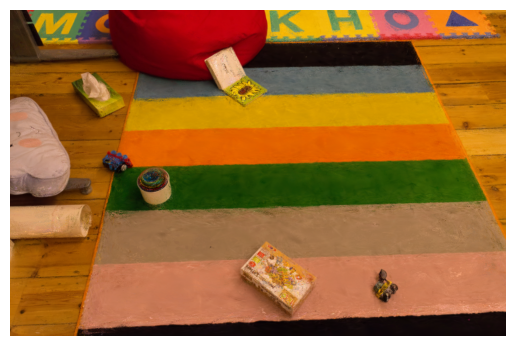

In [43]:
# Display the image.
plt.imshow(np.array(computed_image).reshape((IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
plt.axis('off')